In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 12})
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.decomposition import PCA
import json
from argparse import Namespace

In [3]:
def read_and_extract_coverage(cov_bed):
    df = pd.read_csv(cov_bed, sep="\t", header=None)
    roi_depth = df.iloc[:, -4]
    return roi_depth

# Comparison of Library QC

1. Within replicate pearson and spearman's correlation of coverage
2. PCA plots

# In-house library

In [4]:
meta_file = "/data5/deepro/starrseq/data/meta_data/metadata.json"
all_lib_names = ["input", "control"]
store_dir = "/data5/deepro/starrseq/main_library/2_quality_control_lib/data/"

In [5]:
def create_args(meta_file, lib_name):
    with open(meta_file, "r") as f: 
        meta_dict = json.load(f)
        
    args = Namespace(
        # from metadata file
        library_prefix = meta_dict[lib_name]["prefix"],
        library_reps = meta_dict[lib_name]["replicates"],
        library_pair= meta_dict[lib_name]["read_pairs"],
        library_umi = meta_dict[lib_name]["umi"],
        library_suffix = meta_dict[lib_name]["suffix"],
        library_short = meta_dict[lib_name]["shortform"],
        reference_genome = meta_dict["genome"]["ref_fasta"],
        reference_genome_twobit = meta_dict["genome"]["ref_twobit"],
        genome_sizes = meta_dict["genome"]["chrom_sizes"],
        roi_file = meta_dict["roi"]["sorted"],
        roi_window_file = meta_dict["roi"]["window"],
    )

    return args

def get_depth_bed_filepaths(store_dir, lib_short, lib_prefix, lib_rep):
    return os.path.join(store_dir, "cov", lib_short, f"{lib_prefix}_{lib_rep}.bed")

def get_lib_depth_beds_filepaths(store_dir, lib_short, lib_prefix, lib_reps):
    depth_beds = [get_depth_bed_filepaths(store_dir, lib_short, lib_prefix, lib_rep) for lib_rep in lib_reps.split()]
    return depth_beds

def get_meta_df(meta_file, all_lib_names, store_dir):
    lib_dfs = []

    for lib_name in all_lib_names:
        lib_args = create_args(meta_file, lib_name)
        lib_beds = get_lib_depth_beds_filepaths(store_dir, lib_args.library_short, lib_args.library_prefix, lib_args.library_reps)
        lib_df = pd.concat(list(map(read_and_extract_coverage, lib_beds)), axis=1)
        lib_df.columns = [f"{lib_name.upper()} Rep {i}" for i in range(1, len(lib_beds)+1)] 
        lib_dfs.append(lib_df)
    meta_df = pd.concat([df for df in lib_dfs], axis=1) 
    return meta_df

In [6]:
def get_within_lib_correlation(meta_df, cmethod):
    melted_df = meta_df.corr(method=cmethod).reset_index().rename(columns={"index": "variable_1"}).melt(id_vars=["variable_1"])
    # filter same pair correlation
    melted_df = melted_df.loc[melted_df.variable_1!=melted_df.variable]
    # filter across library replicate
    melted_df = melted_df.loc[melted_df.variable_1.str.split(expand=True).iloc[:, 0]==melted_df.variable.str.split(expand=True).iloc[:, 0]]
    return melted_df

In [7]:
our_lib_meta = get_meta_df(meta_file, all_lib_names, store_dir)


In [8]:
our_lib_pcorr = get_within_lib_correlation(our_lib_meta, "pearson")
our_lib_pcorr["dataset"] = "In-house dataset"
our_lib_scorr = get_within_lib_correlation(our_lib_meta, "spearman")
our_lib_scorr["dataset"] = "In-house dataset"

# Wang et. al. library

In [9]:
meta_file = "/data5/deepro/starrseq/data/meta_data/wang_kellis_metadata.json"
all_lib_names = ["input", "output"]
store_dir = "/data5/deepro/starrseq/others/2_quality_control_lib/data/wang_kellis/with_dedup"

In [10]:
wk_meta = get_meta_df(meta_file, all_lib_names, store_dir)

In [11]:
wk_pcorr = get_within_lib_correlation(wk_meta, "pearson")
wk_pcorr["dataset"] = "Wang_Kellis"
wk_scorr = get_within_lib_correlation(wk_meta, "spearman")
wk_scorr["dataset"] = "Wang_Kellis"

# Johnson et. al. library

In [12]:
meta_file = "/data5/deepro/starrseq/data/meta_data/johnson_reddy_metadata.json"
all_lib_names = ["input", "output"]
store_dir = "/data5/deepro/starrseq/others/2_quality_control_lib/data/johnson_reddy/with_dedup"

In [13]:
jr_meta = get_meta_df(meta_file, all_lib_names, store_dir)

In [14]:
jr_pcorr = get_within_lib_correlation(jr_meta, "pearson")
jr_pcorr["dataset"] = "Johnson_Reddy"
jr_scorr = get_within_lib_correlation(jr_meta, "spearman")
jr_scorr["dataset"] = "Johnson_Reddy"

In [15]:
pcorr_df = pd.concat([our_lib_pcorr, wk_pcorr, jr_pcorr])
scorr_df = pd.concat([our_lib_scorr, wk_scorr, jr_scorr])

In [16]:
pcorr_df["correlation"] = "pearson"
scorr_df["correlation"] = "spearman"

In [17]:
corr_df = pd.concat([pcorr_df, scorr_df])

# Fig S4

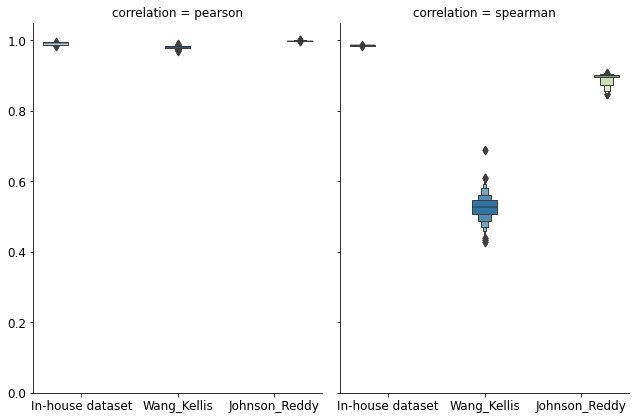

In [18]:
sns_ax = sns.catplot(
    data=corr_df, 
    x="dataset", 
    y="value", 
    kind="boxen", 
    hue="dataset",
    col="correlation",
    aspect=0.75, 
    height=6, 
    dodge=True,
    # edgecolor="k",
    palette="Paired",
    sharey=True
    )

sns_ax.axes[0][0].set_ylim((0, 1.05))
sns_ax.axes[0][1].set_ylim((0, 1.05))
sns_ax.set_xlabels("")
sns_ax.set_ylabels("")


# PCA plots comparison

In [19]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

df = pd.DataFrame(data=np.random.normal(0, 1, (50, 8)))


pca = PCA(n_components=4).fit_transform(df)

In [20]:
# load dataset
from sklearn import datasets
iris = datasets.load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)

# normalize data
from sklearn import preprocessing
data_scaled = pd.DataFrame(preprocessing.scale(df),columns = df.columns) 

# PCA
pca = PCA(n_components=2).fit_transform(data_scaled)

In [21]:
def get_pca_components(meta_df):
    meta_df_norm = (meta_df-meta_df.mean())/meta_df.std()
    pca = PCA(n_components=2)

    components = pca.fit_transform(meta_df_norm.T)

    pca_df = pd.DataFrame({
        "lib_info": meta_df_norm.columns,
        "pca_comp1": components[:, 0],
        "pca_comp2": components[:, 1],
        "library": [c.split()[0] for c in meta_df_norm.columns],
        # "alpha": [(i+1)/len(components[:, 0]) for i in range(len(components[:, 0]))]
    })

    return pca_df


def get_pca_plots(meta_dfs, dataset_names):

    pca_dfs = [get_pca_components(mdf) for mdf in meta_dfs]
    fig, ax = plt.subplots(1, len(meta_dfs), figsize=(18,6), sharex=True, sharey=True)
    for i, pca_df in enumerate(pca_dfs):
        sns.scatterplot(
            data=pca_df, 
            x="pca_comp1", 
            y="pca_comp2", 
            hue="library", 
            style="library", 
            legend=True, 
            ax=ax[i], 
            s=100,
            alpha=1.,
            # linewidth=1.05,
            # edgecolor="k",
            # linestyle='--',
            )
        ax[i].set_title(dataset_names[i])
        ax[i].legend(loc="upper left")

    return fig

# Fig S5

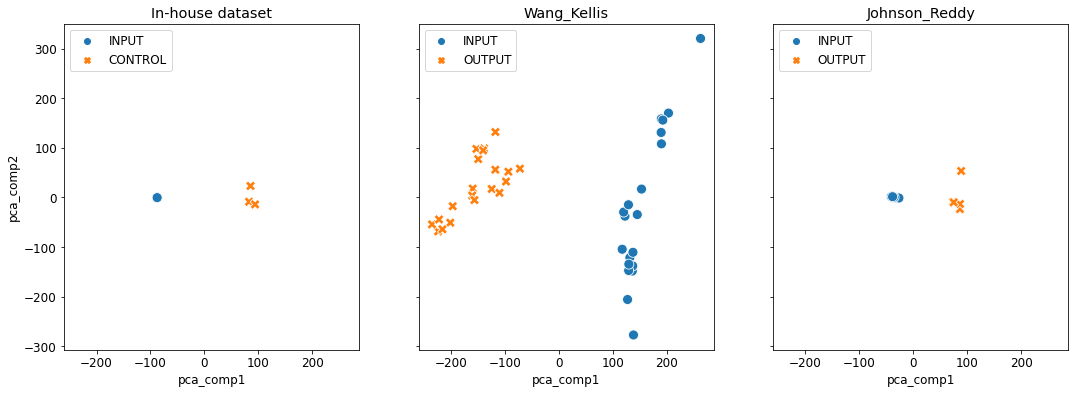

In [22]:
f = get_pca_plots([our_lib_meta, wk_meta, jr_meta], ["In-house dataset", "Wang_Kellis", "Johnson_Reddy"])
